## My master thesis - revisited with Python

In this notebook I've decided to share (a part of) my civil engineering master thesis. This is obviously not the actual paper itself, but my current take on the topic where I used Python for calculations and simulating the results - at the time of writing my real thesis I used Microsoft Project for modeling the project schedule and an additional piece of software called Risky Project for the Monte Carlo simulation. 

My thesis titled *'Risk assessment and management methods in construction projects using Monte Carlo simulation'* focused, as title suggests, on the topic of risk (different kinds, as there are many) in construction projects. In the paper, I have also included an example / a simulation illustrating how small deviations from the estimated time for each project task can result in a massive difference in the overall project duration (time risk).

This simulation is exactly what I recreated now using Python. I will skip the theoretical introduction, as you can simply visit the links below for that:

https://en.wikipedia.org/wiki/Risk_management

https://en.wikipedia.org/wiki/Critical_path_method (CPM)

https://en.wikipedia.org/wiki/Program_evaluation_and_review_technique (PERT)

https://en.wikipedia.org/wiki/Monte_Carlo_method

https://en.wikipedia.org/wiki/PERT_distribution

Let's begin with all the imports and the logic of the CPM algorithm.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# forward pass of the CPM
def fpass(tasks):
    for t in tasks:
        if t.pre:
            t.ES = max([(p.EF, p.next.append(t))[0] for p in t.pre])
        else:
            t.ES = 0
        t.EF = t.ES + t.duration

# backward pass of the CPM
def bpass(tasks):
    finish =[]
    maxx = max([t.EF for t in tasks])
    for t in tasks[::-1]:
        if t.next:
            t.LF = min([n.LS for n in t.next])
        else:
            t.LF = maxx
        t.LS = t.LF - t.duration
        finish.append(t.LF)
        t.comp_slack()
    return max(finish)

# packed together for convenience
def cpm_pert(tasks):
    fpass(tasks)
    return bpass(tasks)

# convenience function for resetting start and finish times
def reset_tasks(tasks): [task.reset() for task in tasks]

Now let's create a simple Task class - a template for Task objects and a base for other 'Task' classes. 

ES = early start, EF = early finish, LS = late start, LF = late finish

In [2]:
class Task:
    def __init__(self, code, duration=0, pre=None, desc=None):
        self.code = code # short representation of the task (string)
        self.duration = duration
        self.pre = pre or [] # predecessor task list
        self.desc = desc or self.code
        self.ES = None # early start
        self.EF = None # early finish
        self.LS = None # late start
        self.LF = None # late finish
        self.next = [] # successor task list
        self.slack = None
        self.critical = None

    # string representation when printed
    def __str__(self):
        return f'Task {self.code} - ES: {round(self.ES, 1)} - EF: {round(self.EF, 1)} - LS: {round(self.LS, 1)} - LF: {round(self.LF, 1)} - Slack: {self.slack}' + f' - Critical' * bool(self.critical)
    
    def comp_slack(self):
        self.slack = self.LS - self.ES
        self.slack = round(self.slack, 1)
        if self.slack:
            self.critical = ''
        else:
            self.critical = True

    def reset(self):
        self.ES = None
        self.EF = None
        self.LS = None
        self.LF = None
        self.next = []
        self.slack = None
        self.critical = None

To demonstrate that all the above code works, let's build a sample project model with 11 tasks ('A' through 'K') and run the CPM algorithm to see which tasks make up the critical chain. This example is much simpler (shorter) than what I used in my thesis, but will illustrate the point well.

We can find the CPM estimate of the project duration by finding the maximum value of the late (or early) finish of all tasks.

In [3]:
task_a = Task('A', 4)
task_b = Task('B', 6, pre=[task_a])
task_c = Task('C', 3, pre=[task_b])
task_d = Task('D', 5, pre=[task_b])
task_e = Task('E', 8, pre=[task_b])
task_f = Task('F', 4, pre=[task_c])
task_g = Task('G', 6, pre=[task_c, task_d])
task_h = Task('H', 4, pre=[task_d, task_e])
task_i = Task('I', 8, pre=[task_f, task_g])
task_j = Task('J', 3, pre=[task_h])
task_k = Task('K', 3, pre=[task_g, task_i, task_j])

tasks = [task_a, task_b, task_c, task_d, task_e, task_f, task_g, task_h, task_i, task_j, task_k]

cpm_pert(tasks)
cpm_est = max([t.LF for t in tasks])

for i in tasks:
    print(i)

print(f'CPM estimate: {cpm_est}')

Task A - ES: 0 - EF: 4 - LS: 0 - LF: 4 - Slack: 0 - Critical
Task B - ES: 4 - EF: 10 - LS: 4 - LF: 10 - Slack: 0 - Critical
Task C - ES: 10 - EF: 13 - LS: 12 - LF: 15 - Slack: 2
Task D - ES: 10 - EF: 15 - LS: 10 - LF: 15 - Slack: 0 - Critical
Task E - ES: 10 - EF: 18 - LS: 14 - LF: 22 - Slack: 4
Task F - ES: 13 - EF: 17 - LS: 17 - LF: 21 - Slack: 4
Task G - ES: 15 - EF: 21 - LS: 15 - LF: 21 - Slack: 0 - Critical
Task H - ES: 18 - EF: 22 - LS: 22 - LF: 26 - Slack: 4
Task I - ES: 21 - EF: 29 - LS: 21 - LF: 29 - Slack: 0 - Critical
Task J - ES: 22 - EF: 25 - LS: 26 - LF: 29 - Slack: 4
Task K - ES: 29 - EF: 32 - LS: 29 - LF: 32 - Slack: 0 - Critical
CPM estimate: 32


Reusing the previous Task class as a base, I created a new PertTask class which uses a 3-point PERT estimate to determine its duration. The 3 points / 'times' are - optimistic (o), most common/likely (m) and pessimistic (p). The m-time is given 4 times more 'weight' as other two.

In [4]:
class PertTask(Task):
    def reset(self):
        super().reset()
        self.duration = (self.o + 4 * self.m + self.p) / 6
        # PERT estimate of the task duration

    def __init__(self, code, o=0, m=0, p=0, pre=None, desc=None):
        super().__init__(code, pre=pre, desc=desc)
        self.o = o
        self.m = m
        self.p = p
        self.reset()

In the next step I recreated the same project tasks using the new PertTask class.

In my original paper, for the sake of simplicity, together with my professor we decided that it would be 'sensible' to assume the optimistic and pessimistic times as multiples (0.8x and 1.6x respectively) of the base (most likely time) time. I used the same assumption here, but in the real world scenario all three times would have to be determined based on experience.

The PERT estimate of the project duration is determined similarly to the CPM estimate.

In [5]:
task_a = PertTask('A', o=3.2, m=4, p=6.4)
task_b = PertTask('B', o=4.8, m=6, p=9.6, pre=[task_a])
task_c = PertTask('C', o=2.4, m=3, p=4.8, pre=[task_b])
task_d = PertTask('D', o=4, m=5, p=8, pre=[task_b])
task_e = PertTask('E', o=6.4, m=8, p=12.8, pre=[task_b])
task_f = PertTask('F', o=3.2, m=4, p=6.4, pre=[task_c])
task_g = PertTask('G', o=4.8, m=6, p=9.6, pre=[task_c, task_d])
task_h = PertTask('H', o=3.2, m=4, p=6.4, pre=[task_d, task_e])
task_i = PertTask('I', o=6.4, m=8, p=12.8, pre=[task_f, task_g])
task_j = PertTask('J', o=2.4, m=3, p=4.8, pre=[task_h])
task_k = PertTask('K', o=2.4, m=3, p=4.8, pre=[task_g, task_i, task_j])

tasks = [task_a, task_b, task_c, task_d, task_e, task_f, task_g, task_h, task_i, task_j, task_k]

cpm_pert(tasks)
pert_est = max([t.LF for t in tasks])

for i in tasks:
    print(i)

print(f'PERT estimate: {round(pert_est, 1)}')

Task A - ES: 0 - EF: 4.3 - LS: 0.0 - LF: 4.3 - Slack: 0.0 - Critical
Task B - ES: 4.3 - EF: 10.7 - LS: 4.3 - LF: 10.7 - Slack: 0.0 - Critical
Task C - ES: 10.7 - EF: 13.9 - LS: 12.8 - LF: 16.0 - Slack: 2.1
Task D - ES: 10.7 - EF: 16.0 - LS: 10.7 - LF: 16.0 - Slack: 0.0 - Critical
Task E - ES: 10.7 - EF: 19.2 - LS: 14.9 - LF: 23.5 - Slack: 4.3
Task F - ES: 13.9 - EF: 18.1 - LS: 18.1 - LF: 22.4 - Slack: 4.3
Task G - ES: 16.0 - EF: 22.4 - LS: 16.0 - LF: 22.4 - Slack: 0.0 - Critical
Task H - ES: 19.2 - EF: 23.5 - LS: 23.5 - LF: 27.7 - Slack: 4.3
Task I - ES: 22.4 - EF: 30.9 - LS: 22.4 - LF: 30.9 - Slack: 0.0 - Critical
Task J - ES: 23.5 - EF: 26.7 - LS: 27.7 - LF: 30.9 - Slack: 4.3
Task K - ES: 30.9 - EF: 34.1 - LS: 30.9 - LF: 34.1 - Slack: 0.0 - Critical
PERT estimate: 34.1


We can see that in both cases the same tasks make up the critical chain - tasks A, B, D, G, I and K. However, our estimates differ slightly. We got 32 *[units]* and 34.1 *[units]* for CPM and PERT estimates respectively, that is the difference of 2.1 *[units]* or 6.6%. How big the difference is in the probability of completing the project within those times, will be illustrated using a graph.

Now is the time to create the final iteration of our Task class, the PertBetaTask class. The new objects are able to draw their duration times randomly from a PERT-beta distribution.

In [6]:
def pert_beta(o, m, p, lambd=4, n=None):
    alpha = lambd * (m - o) / (p - o) + 1
    beta = lambd * (p - m) / (p - o) + 1
    x = np.random.beta(alpha, beta, n)
    # np.random.beta lands us in the [0, 1] range - we need to scale and move the result
    return x * (p - o) + o

class PertBetaTask(PertTask):
    def reset(self, lambd=4):
        super().reset()
        self.duration = pert_beta(self.o, self.m, self.p, lambd=lambd)

As a proof of concept, the graph below shows the duration distribution of a single task using the sample size of *one million*. Marked in gray are the outer bounds of the distribution (optimistic and pessimistic times), while the red line marks the most likely time.

The shape of the distribution and its skewness can be explained in the real life by a large number of factors. First, there may be tangible benefits and incentives for finishing the work before schedule, which make it that much more probable. But on the other hand, there are just as many (if not more) things working against that, some within and some outside our control, and that inevitably leads to project delays.

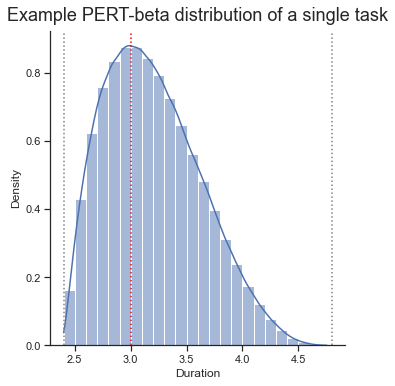

In [7]:
durations = []
example_task = PertBetaTask('example', o=2.4, m=3, p=4.8)

for _ in range(1_000_000):
    example_task.reset()
    durations.append(example_task.duration)

# plotting
sns.set_theme(style='ticks')
sns.displot(durations, kde='True', binwidth=0.1, stat='density')
# density on the y-axis means the chart is normalized so that the total area under the chart = 1 (from t_min to t_max)
plt.axvline(example_task.o, c='gray', ls=':')
plt.axvline(example_task.m, c='red', ls=':')
plt.axvline(example_task.p, c='gray', ls=':')
plt.title('Example PERT-beta distribution of a single task', pad=10, size=18)
plt.xlabel('Duration')
sns.despine()

Time for the Monte Carlo simulation itself. Modelled (copied...) for the third time, now with the tasks using the PertBetaTask class, the project is run *100 thousand times* - and each time with slightly different durations for all of it 11 tasks. The durations for the tasks are drawn randomly from the PERT distribution demonstrated above.

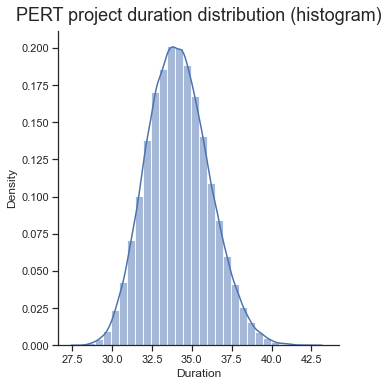

In [8]:
task_a = PertBetaTask('A', o=3.2, m=4, p=6.4)
task_b = PertBetaTask('B', o=4.8, m=6, p=9.6, pre=[task_a])
task_c = PertBetaTask('C', o=2.4, m=3, p=4.8, pre=[task_b])
task_d = PertBetaTask('D', o=4, m=5, p=8, pre=[task_b])
task_e = PertBetaTask('E', o=6.4, m=8, p=12.8, pre=[task_b])
task_f = PertBetaTask('F', o=3.2, m=4, p=6.4, pre=[task_c])
task_g = PertBetaTask('G', o=4.8, m=6, p=9.6, pre=[task_c, task_d])
task_h = PertBetaTask('H', o=3.2, m=4, p=6.4, pre=[task_d, task_e])
task_i = PertBetaTask('I', o=6.4, m=8, p=12.8, pre=[task_f, task_g])
task_j = PertBetaTask('J', o=2.4, m=3, p=4.8, pre=[task_h])
task_k = PertBetaTask('K', o=2.4, m=3, p=4.8, pre=[task_g, task_i, task_j])

durations = []
tasks = [task_a, task_b, task_c, task_d, task_e, task_f, task_g, task_h, task_i, task_j, task_k]

# Running X number of simulations (Monte Carlo)
monte = 100_000
for _ in range(monte):
    reset_tasks(tasks)
    durations.append(cpm_pert(tasks))

# plotting
sns.displot(durations, binwidth=0.5, kde=True, stat='density')
plt.title('PERT project duration distribution (histogram)', pad=10, size=18)
plt.xlabel('Duration');

The graph above shows the probability (density) distribution for the overall project duration. And due to the central limit theorem being true, we obtained a normal distribution.

The graph below illustrates the same data but in a different way. It shows how likely it is to finish the project on or before the specified date / duration (with project start being time '0').

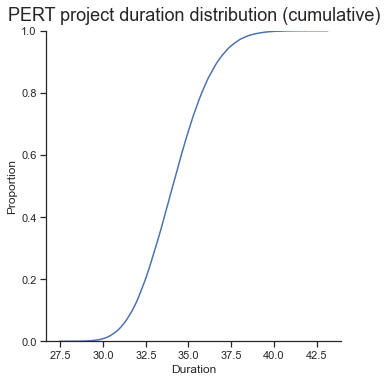

In [9]:
# plotting
sns.displot(durations, kind='ecdf')
plt.title('PERT project duration distribution (cumulative)', pad=10, size=18)
plt.xlabel('Duration');

The graph below shows where do the CPM and PERT estimates land on the distribution chart. The CPM estimate is marked in gray and the PERT estimate in red. Now we can see how big the difference in the estimates is. The area under the curve gives us the probability of finishing the project on or before the specified date / duration (simillarly to the graph above and here marked gray, up until the CPM estimate).

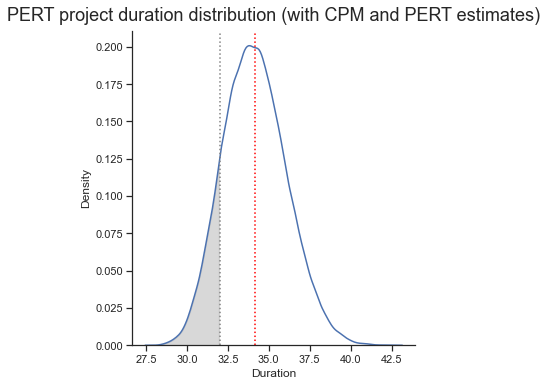

In [10]:
# plotting
plot_a = sns.displot(durations, kind='kde', clip=[min(durations), max(durations)])
plt.axvline(cpm_est, c='gray', ls=':')
plt.axvline(pert_est, c='red', ls=':')

x1 = plot_a.ax.lines[0].get_xydata()[:, 0]
x1 = [i for i in x1 if i <= cpm_est]
y1 = plot_a.ax.lines[0].get_xydata()[:, 1]
y1 = y1[:len(x1)]

plt.fill_between(x1, y1, color='gray', alpha=0.3)
plt.title('PERT project duration distribution (with CPM and PERT estimates)', pad=10, size=18)
plt.xlabel('Duration');

Last three graphs show the CPM and PERT estimates (and their percentiles), as well as the 95th percentile and the corresponding duration (date).

CPM estimate: 32
CPM percentile: 13.2


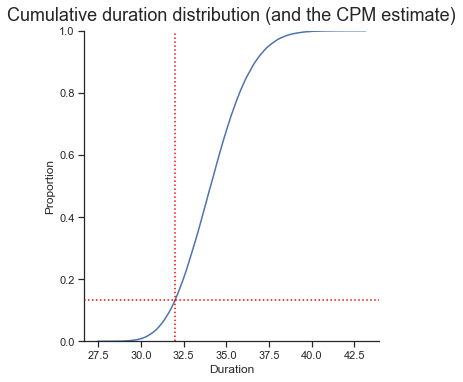

In [11]:
# plotting
sns.displot(durations, kind='ecdf');

cpm_percentile = len([i for i in durations if i <= cpm_est]) / monte * 100
plt.axvline(cpm_est, c='red', ls=':')
plt.axhline(cpm_percentile/100, c='red', ls=':')

# pert_percentile = len([i for i in durations if i <= pert_est]) / monte * 100
# plt.axvline(pert_est, c='red', ls=':')
# plt.axhline(pert_percentile/100, c='red', ls=':')
# print(pert_percentile)

# sure_percentile = 95
# sure = np.percentile(durations, sure_percentile)
# plt.axvline(sure, c='red', ls=':')
# plt.axhline(sure_percentile/100, c='red', ls=':')
# print(sure)

plt.title('Cumulative duration distribution (and the CPM estimate)', pad=10, size=18)
plt.xlabel('Duration');

print(f'CPM estimate: {round(cpm_est, 1)}')
print(f'CPM percentile: {round(cpm_percentile, 1)}')

PERT estimate: 34.1
PERT percentile: 51.1


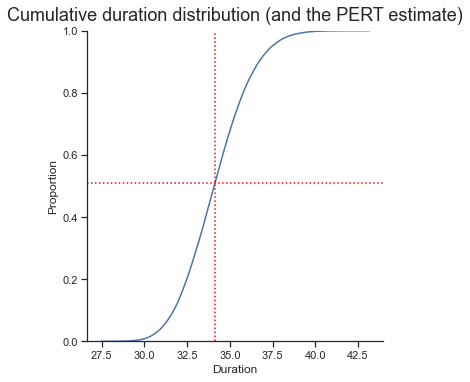

In [12]:
# plotting
sns.displot(durations, kind='ecdf');

pert_percentile = len([i for i in durations if i <= pert_est]) / monte * 100
plt.axvline(pert_est, c='red', ls=':')
plt.axhline(pert_percentile/100, c='red', ls=':')

plt.title('Cumulative duration distribution (and the PERT estimate)', pad=10, size=18)
plt.xlabel('Duration');

print(f'PERT estimate: {round(pert_est, 1)}')
print(f'PERT percentile: {round(pert_percentile, 1)}')

"Sure" estimate: 37.5
"Sure" percentile: 95


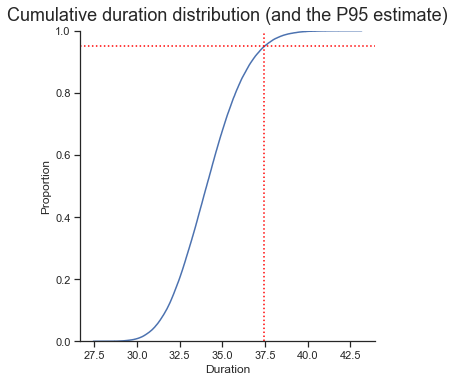

In [13]:
# plotting
sns.displot(durations, kind='ecdf');

sure_percentile = 95
sure = np.percentile(durations, sure_percentile)
plt.axvline(sure, c='red', ls=':')
plt.axhline(sure_percentile/100, c='red', ls=':')

plt.title('Cumulative duration distribution (and the P95 estimate)', pad=10, size=18)
plt.xlabel('Duration');

print(f'"Sure" estimate: {round(sure, 1)}')
print(f'"Sure" percentile: {round(sure_percentile, 1)}')

It is impressive how our first (CPM) estimate turns out to give us only about 13.2% probability of finishing the project on or before that point in time. This is of course highly dependent on our assumptions and other estimates.

The PERT estimate around 50% (51.1%) actually makes sense - especially when considering, that the PERT estimate of the task duration is de facto its expected value.

In [14]:
print(f'Min duration: {round(min(durations), 1)}')
print(f'Max duration: {round(max(durations), 1)}')
print(f'CPM estimate: {round(cpm_est, 1)}')
print(f'PERT estimate: {round(pert_est, 1)}')
print(f'"Sure" / P95 estimate: {round(sure, 1)}')

Min duration: 27.5
Max duration: 43.2
CPM estimate: 32
PERT estimate: 34.1
"Sure" / P95 estimate: 37.5


In order to be relatively "sure" about the project completion time, it would make sense to assume the P95 estimate of 37.5 *[units]*. That is 5.5 *[units]* or 17.2% more than our CPM estimate.